### Utils

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import random
import numpy as np
import torch
from torch.nn import functional as F
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.utils import is_undirected, to_undirected, remove_self_loops, to_dense_adj, dense_to_sparse
import e3nn
from e3nn import o3
from functools import partial

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))

from src.utils.plot_utils import plot_2d, plot_3d
from src.utils.train_utils import run_experiment
from src.models import MPNNModel, EGNNModel, GVPGNNModel, TFNModel, SchNetModel, DimeNetPPModel, MACEModel

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")
print(f"Using device: {device}")

PyTorch version 1.13.1+cu116
PyG version 2.2.0
e3nn version 0.5.1
Using device: cpu


In [ ]:
def create_kchains(k):
    assert k >= 2
    
    dataset = []

    # Graph 0
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[-4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([0])  # Label 0
    data1 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data1.edge_index = to_undirected(data1.edge_index)
    dataset.append(data1)
    
    # Graph 1
    atoms = torch.LongTensor( [0] + [0] + [0]*(k-1) + [0] )
    edge_index = torch.LongTensor( [ [i for i in range((k+2) - 1)], [i for i in range(1, k+2)] ] )
    pos = torch.FloatTensor(
        [[4, -3, 0]] + 
        [[0, 5*i , 0] for i in range(k)] + 
        [[4, 5*(k-1) + 3, 0]]
    )
    center_of_mass = torch.mean(pos, dim=0)
    pos = pos - center_of_mass
    y = torch.LongTensor([1])  # Label 1
    data2 = Data(atoms=atoms, edge_index=edge_index, pos=pos, y=y)
    data2.edge_index = to_undirected(data2.edge_index)
    dataset.append(data2)
    
    return dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline


def plot_res(d, name, title):
  fig, ax = plt.subplots()

  x = [2, 3,4,5,6,7]
  for key in d.keys():
    l = d[key]

    means = np.mean(l, axis= 1)
    #stds = np.std(l, axis= 1)
    print(means)
    ax.plot(x, means, label = str(key)+"-hop adj")

  plt.title(title)
  fig.legend(loc='lower right')
  plt.xlabel('Number of layers')
  plt.ylabel('Validation accuracy')


  plt.savefig(name+'.png')

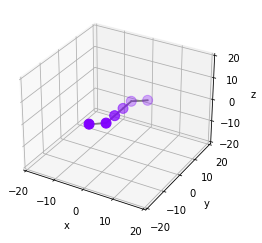

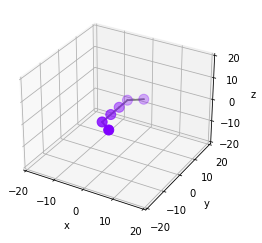

In [ ]:
k = 4

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    # plot_2d(data, lim=5*k)
    plot_3d(data, lim=5*k)

In [ ]:

from torch_geometric.data import Data
from torch_geometric.data.datapipes import functional_transform
from torch_geometric.transforms import BaseTransform
from torch_geometric.typing import SparseTensor
from torch_geometric.utils import coalesce, remove_self_loops

def two_hop(data):
    edge_index, edge_attr = data.edge_index, data.edge_attr
    N = data.num_nodes

    adj = SparseTensor.from_edge_index(edge_index, sparse_sizes=(N, N))

    adj = adj @ adj
    row, col, _ = adj.coo()
    edge_index2 = torch.stack([row, col], dim=0)
    edge_index2, _ = remove_self_loops(edge_index2)

    edge_index = torch.cat([edge_index, edge_index2], dim=1)
    if edge_attr is None:
        data.edge_index = coalesce(edge_index, num_nodes=N)
    else:
        # We treat newly added edge features as "zero-features":
        edge_attr2 = edge_attr.new_zeros(edge_index2.size(1),
                                          *edge_attr.size()[1:])
        edge_attr = torch.cat([edge_attr, edge_attr2], dim=0)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N)
        data.edge_index, data.edge_attr = edge_index, edge_attr

    return data

def n_hop_plus_init(data, n):
    edge_index, edge_attr = data.edge_index, data.edge_attr
    N = data.num_nodes

    adj_0 = SparseTensor.from_edge_index(edge_index, sparse_sizes=(N, N))
    adj_n = adj_0
    #print(adj_0)
    for i in range(n):
      adj_n = adj_n @ adj_0
    #print(adj_n)

    row, col, _ = adj_n.coo()
    edge_index2 = torch.stack([row, col], dim=0)
    edge_index2, _ = remove_self_loops(edge_index2)

    edge_index = torch.cat([edge_index, edge_index2], dim=1)
    if edge_attr is None:
        data.edge_index = coalesce(edge_index, num_nodes=N)
    else:
        # We treat newly added edge features as "zero-features":
        edge_attr2 = edge_attr.new_zeros(edge_index2.size(1),
                                          *edge_attr.size()[1:])
        edge_attr = torch.cat([edge_attr, edge_attr2], dim=0)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N)
        data.edge_index, data.edge_attr = edge_index, edge_attr

    return data 

def n_hop(data, n):
    edge_index, edge_attr = data.edge_index, data.edge_attr
    N = data.num_nodes

    adj_0 = SparseTensor.from_edge_index(edge_index, sparse_sizes=(N, N))
    adj_n = adj_0
    #print(adj_0)
    for i in range(n):
      adj_n = adj_n @ adj_0
    #print(adj_n)

    row, col, _ = adj_n.coo()
    edge_index2 = torch.stack([row, col], dim=0)
    edge_index2, _ = remove_self_loops(edge_index2)

    #edge_index = torch.cat([edge_index, edge_index2], dim=1)
    edge_index = edge_index2
    if edge_attr is None:
        data.edge_index = coalesce(edge_index, num_nodes=N)
    else:
        # We treat newly added edge features as "zero-features":
        edge_attr2 = edge_attr.new_zeros(edge_index2.size(1),
                                          *edge_attr.size()[1:])
        edge_attr = torch.cat([edge_attr, edge_attr2], dim=0)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N)
        data.edge_index, data.edge_attr = edge_index, edge_attr

    return data


def n_hop(data, n):
    datas = []
    
    edge_index, edge_attr = data.edge_index, data.edge_attr
    N = data.num_nodes

    adj_0 = SparseTensor.from_edge_index(edge_index, sparse_sizes=(N, N))
    adj_n = adj_0
    #print(adj_0)
    for i in range(n):
      adj_n = adj_n @ adj_0
    #print(adj_n)

    row, col, _ = adj_n.coo()
    edge_index2 = torch.stack([row, col], dim=0)
    edge_index2, _ = remove_self_loops(edge_index2)

    #edge_index = torch.cat([edge_index, edge_index2], dim=1)
    edge_index = edge_index2
    if edge_attr is None:
        data.edge_index = coalesce(edge_index, num_nodes=N)
    else:
        # We treat newly added edge features as "zero-features":
        edge_attr2 = edge_attr.new_zeros(edge_index2.size(1),
                                          *edge_attr.size()[1:])
        edge_attr = torch.cat([edge_attr, edge_attr2], dim=0)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N)
        data.edge_index, data.edge_attr = edge_index, edge_attr

    return data


def n_hop_shortest(data, n):
    edge_index, edge_attr = data.edge_index, data.edge_attr
    N = data.num_nodes

    adj_0 = SparseTensor.from_edge_index(edge_index, sparse_sizes=(N, N))
    adj_n = adj_0
    #print(adj_0)
    for i in range(n):
      adj_n = adj_n @ adj_0
    #print(adj_n)

    row, col, _ = adj_n.coo()
    edge_index2 = torch.stack([row, col], dim=0)
    edge_index2, _ = remove_self_loops(edge_index2)

    #edge_index = torch.cat([edge_index, edge_index2], dim=1)
    edge_index = edge_index2
    if edge_attr is None:
        data.edge_index = coalesce(edge_index, num_nodes=N)
    else:
        # We treat newly added edge features as "zero-features":
        edge_attr2 = edge_attr.new_zeros(edge_index2.size(1),
                                          *edge_attr.size()[1:])
        edge_attr = torch.cat([edge_attr, edge_attr2], dim=0)
        edge_index, edge_attr = coalesce(edge_index, edge_attr, N)
        data.edge_index, data.edge_attr = edge_index, edge_attr

    return data

### Previous Experiments

SparseTensor(row=tensor([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6]),
             col=tensor([1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5]),
             size=(7, 7), nnz=12, density=24.49%)
SparseTensor(row=tensor([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6]),
             col=tensor([3, 1, 4, 2, 0, 5, 3, 1, 6, 4, 2, 0, 5, 3, 1, 6, 4, 2, 5, 3]),
             size=(7, 7), nnz=20, density=40.82%)


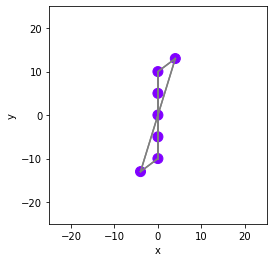

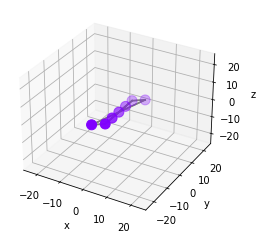

SparseTensor(row=tensor([0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6]),
             col=tensor([1, 0, 2, 1, 3, 2, 4, 3, 5, 4, 6, 5]),
             size=(7, 7), nnz=12, density=24.49%)
SparseTensor(row=tensor([0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6]),
             col=tensor([3, 1, 4, 2, 0, 5, 3, 1, 6, 4, 2, 0, 5, 3, 1, 6, 4, 2, 5, 3]),
             size=(7, 7), nnz=20, density=40.82%)


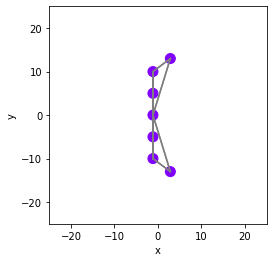

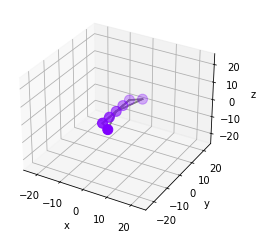

In [ ]:
k = 5

# Create dataset
dataset = create_kchains(k=k)

new_dataset=[]
for data in dataset:
    two_hop_data = n_hop(data, 2)
    new_dataset.append(two_hop_data)
    plot_2d(data, lim=5*k)
    plot_3d(two_hop_data, lim=5*k)

#dataset_3_hop = n_hop(dataset, 1)

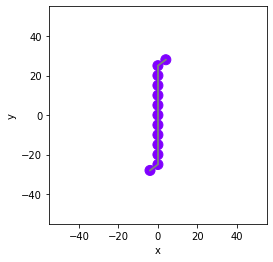

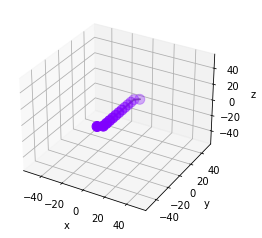

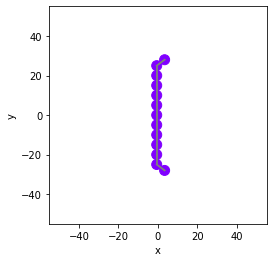

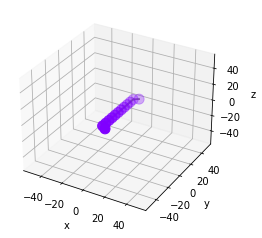


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:10<00:00,  2.13s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.08s ± 0.48. 
 - Best validation accuracy: 70.000 ± 24.495. 
- Test accuracy: 70.0 ± 24.5. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:14<00:00,  2.97s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.96s ± 0.57. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:21<00:00,  4.22s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.21s ± 0.80. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:21<00:00,  4.31s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.30s ± 0.67. 
 - Best validation accuracy: 70.000 ± 24.495. 
- Test accuracy: 70.0 ± 24.5. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:26<00:00,  5.21s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.19s ± 0.87. 
 - Best validation accuracy: 80.000 ± 24.495. 
- Test accuracy: 80.0 ± 24.5. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:33<00:00,  6.73s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.70s ± 0.52. 
 - Best validation accuracy: 80.000 ± 24.495. 
- Test accuracy: 80.0 ± 24.5. 



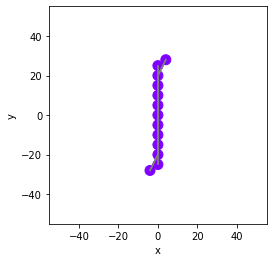

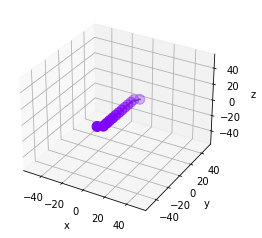

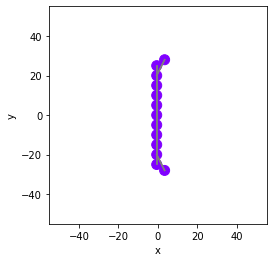

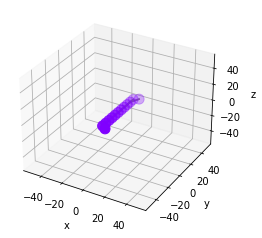


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:10<00:00,  2.15s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.14s ± 0.41. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:14<00:00,  2.88s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.86s ± 0.52. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:19<00:00,  3.87s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.85s ± 0.41. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:22<00:00,  4.52s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.50s ± 0.65. 
 - Best validation accuracy: 70.000 ± 24.495. 
- Test accuracy: 70.0 ± 24.5. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:27<00:00,  5.41s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.40s ± 0.74. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:30<00:00,  6.13s/it]


Done! Averaged over 5 runs: 
 - Training time: 6.11s ± 0.56. 
 - Best validation accuracy: 90.000 ± 20.000. 
- Test accuracy: 90.0 ± 20.0. 



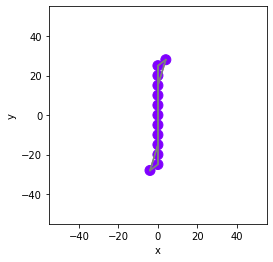

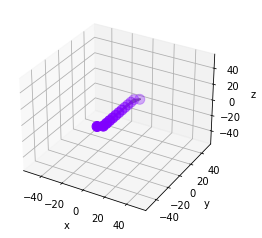

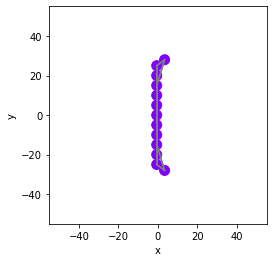

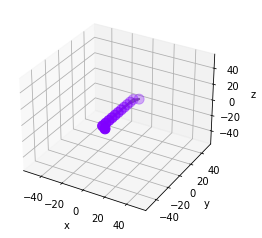


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:13<00:00,  2.71s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.70s ± 0.52. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:19<00:00,  3.83s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.82s ± 0.72. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:21<00:00,  4.26s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.24s ± 0.51. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:27<00:00,  5.51s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.49s ± 0.84. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:32<00:00,  6.55s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.53s ± 0.68. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


Done! Averaged over 5 runs: 
 - Training time: 7.34s ± 0.72. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



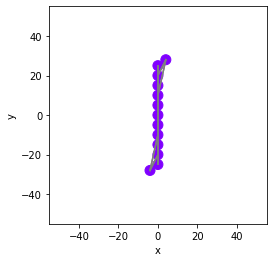

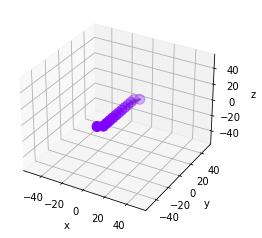

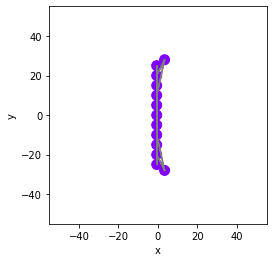

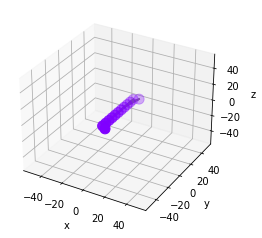


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:12<00:00,  2.48s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.47s ± 0.57. 
 - Best validation accuracy: 90.000 ± 20.000. 
- Test accuracy: 90.0 ± 20.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.28s ± 0.47. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:21<00:00,  4.40s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.38s ± 0.63. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:26<00:00,  5.34s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.32s ± 0.63. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:32<00:00,  6.47s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.45s ± 0.76. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:36<00:00,  7.36s/it]


Done! Averaged over 5 runs: 
 - Training time: 7.33s ± 0.63. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



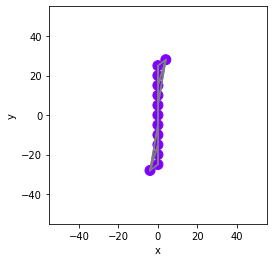

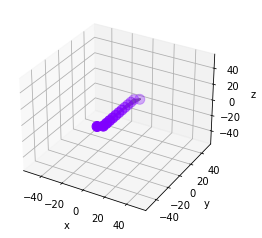

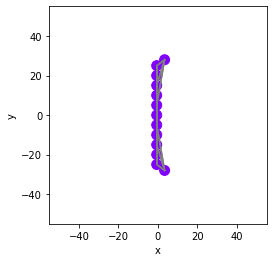

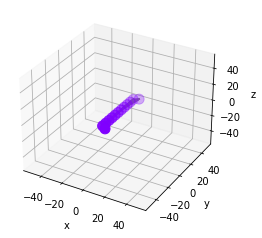


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:14<00:00,  2.95s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.94s ± 0.37. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:19<00:00,  3.99s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.98s ± 0.66. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:26<00:00,  5.39s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.37s ± 0.69. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:32<00:00,  6.59s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.57s ± 0.27. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:38<00:00,  7.72s/it]



Done! Averaged over 5 runs: 
 - Training time: 7.70s ± 0.45. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:44<00:00,  8.85s/it]


Done! Averaged over 5 runs: 
 - Training time: 8.83s ± 0.60. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

{0: [[50.0, 50.0, 50.0, 100.0, 100.0], [100.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 50.0, 100.0, 50.0], [50.0, 50.0, 50.0, 100.0, 100.0], [50.0, 50.0, 100.0, 100.0, 100.0], [50.0, 100.0, 100.0, 100.0, 50.0]], 1: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [50.0, 50.0, 50.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 50.0, 100.0, 100.0, 100.0]], 2: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 3: [[50.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 10

In [ ]:
model_name = "gvp"
d = {} 

for i in range(5):

  k = 11
  d[i] = []
  # Create dataset
  dataset = create_kchains(k=k)

  new_dataset=[]
  for data in dataset:
      two_hop_data = n_hop(data, i)
      new_dataset.append(two_hop_data)
      plot_2d(data, lim=5*k)
      plot_3d(two_hop_data, lim=5*k)
  # Create dataloaders
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
  val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
  test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

  for num_layers in range(k // 2 - 3 , k // 2 + 3):

      print(f"\nNumber of layers: {num_layers}")
      
      model = {
          "mpnn": MPNNModel,
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "egnn": EGNNModel,
          "gvp": GVPGNNModel,
          "tfn": TFNModel,
          "mace": partial(MACEModel, correlation=2),
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
      
      best_val_acc, test_acc, train_time = run_experiment(
          model, 
          dataloader,
          val_loader, 
          test_loader,
          n_epochs=30,
          n_times=5,
          device=device,
          verbose=False
      )
      d[i].append(best_val_acc)

print(d)

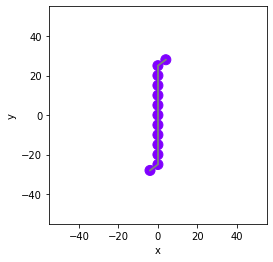

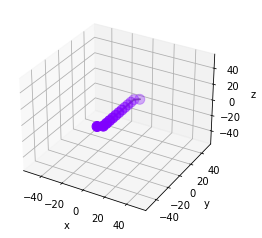

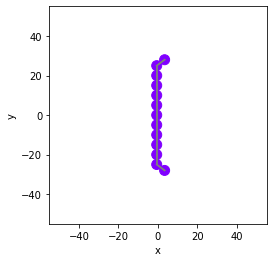

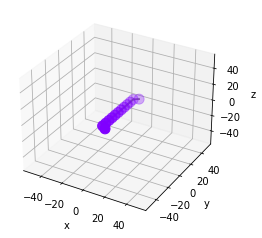


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.93s ± 0.64. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:17<00:00,  3.57s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.55s ± 0.57. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:25<00:00,  5.18s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.16s ± 0.96. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:29<00:00,  5.89s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.87s ± 0.56. 
 - Best validation accuracy: 80.000 ± 24.495. 
- Test accuracy: 80.0 ± 24.5. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:32<00:00,  6.55s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.52s ± 0.82. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:39<00:00,  7.82s/it]



Done! Averaged over 5 runs: 
 - Training time: 7.79s ± 0.31. 
 - Best validation accuracy: 90.000 ± 20.000. 
- Test accuracy: 90.0 ± 20.0. 



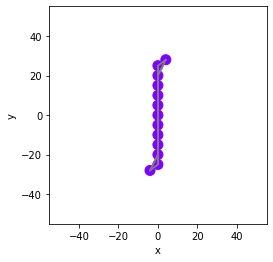

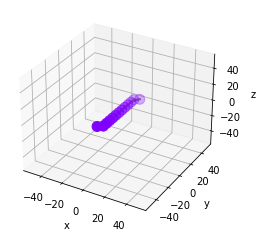

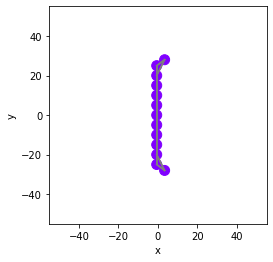

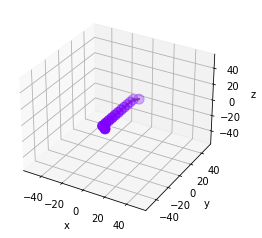


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:16<00:00,  3.28s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.26s ± 0.51. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:21<00:00,  4.33s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.31s ± 0.54. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:30<00:00,  6.18s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.16s ± 1.60. 
 - Best validation accuracy: 70.000 ± 24.495. 
- Test accuracy: 70.0 ± 24.5. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:34<00:00,  6.90s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.87s ± 0.65. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:42<00:00,  8.43s/it]



Done! Averaged over 5 runs: 
 - Training time: 8.40s ± 1.07. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:46<00:00,  9.34s/it]



Done! Averaged over 5 runs: 
 - Training time: 9.30s ± 0.88. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 



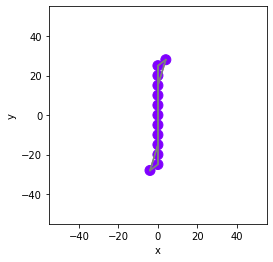

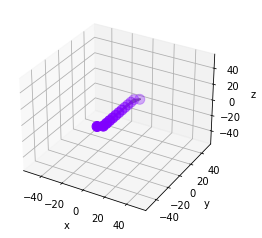

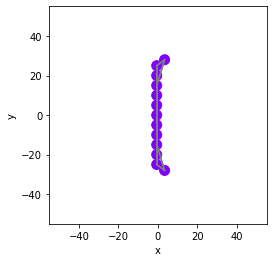

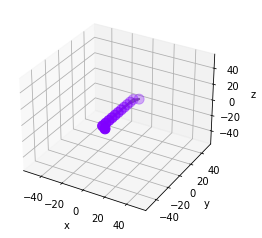


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:14<00:00,  2.87s/it]



Done! Averaged over 5 runs: 
 - Training time: 2.85s ± 0.44. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:20<00:00,  4.07s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.05s ± 0.66. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:25<00:00,  5.15s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.13s ± 0.51. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:33<00:00,  6.67s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.64s ± 1.03. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:39<00:00,  7.81s/it]



Done! Averaged over 5 runs: 
 - Training time: 7.78s ± 0.79. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:43<00:00,  8.61s/it]



Done! Averaged over 5 runs: 
 - Training time: 8.58s ± 0.88. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



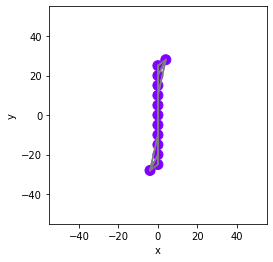

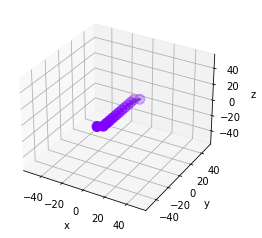

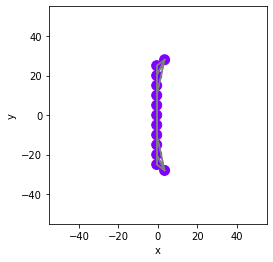

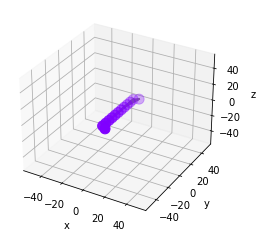


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:16<00:00,  3.30s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.28s ± 0.55. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:22<00:00,  4.41s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.39s ± 0.63. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:28<00:00,  5.64s/it]



Done! Averaged over 5 runs: 
 - Training time: 5.61s ± 0.89. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:35<00:00,  7.16s/it]



Done! Averaged over 5 runs: 
 - Training time: 7.13s ± 0.76. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:40<00:00,  8.10s/it]



Done! Averaged over 5 runs: 
 - Training time: 8.07s ± 1.08. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:51<00:00, 10.20s/it]



Done! Averaged over 5 runs: 
 - Training time: 10.17s ± 0.74. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



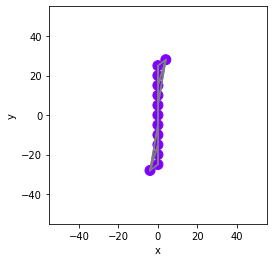

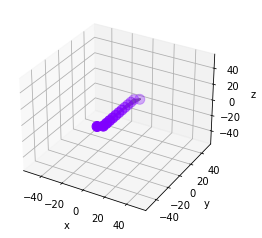

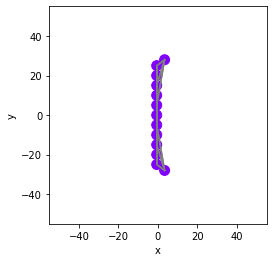

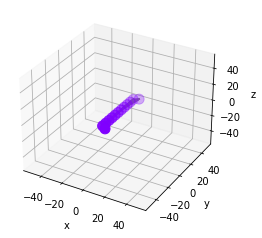


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:17<00:00,  3.49s/it]



Done! Averaged over 5 runs: 
 - Training time: 3.47s ± 0.64. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:23<00:00,  4.66s/it]



Done! Averaged over 5 runs: 
 - Training time: 4.63s ± 0.56. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:31<00:00,  6.23s/it]



Done! Averaged over 5 runs: 
 - Training time: 6.20s ± 0.74. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:40<00:00,  8.02s/it]



Done! Averaged over 5 runs: 
 - Training time: 8.00s ± 2.03. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:45<00:00,  9.05s/it]



Done! Averaged over 5 runs: 
 - Training time: 9.03s ± 1.01. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:50<00:00, 10.09s/it]


Done! Averaged over 5 runs: 
 - Training time: 10.05s ± 1.06. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

{0: [[50.0, 50.0, 50.0, 50.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [50.0, 100.0, 100.0, 50.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [50.0, 100.0, 100.0, 100.0, 100.0]], 1: [[50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 100.0, 50.0, 100.0], [50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 100.0, 50.0, 50.0]], 2: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 3: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0

In [ ]:
model_name = "gvp"
d = {} 

for i in range(5):

  k = 11
  d[i] = []
  # Create dataset
  dataset = create_kchains(k=k)

  new_dataset=[]
  for data in dataset:
      two_hop_data = n_hop_plus_init(data, i)
      new_dataset.append(two_hop_data)
      plot_2d(data, lim=5*k)
      plot_3d(two_hop_data, lim=5*k)
  # Create dataloaders
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
  val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
  test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

  for num_layers in range(k // 2 - 3 , k // 2 + 3):

      print(f"\nNumber of layers: {num_layers}")
      
      model = {
          "mpnn": MPNNModel,
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "egnn": EGNNModel,
          "gvp": GVPGNNModel,
          "tfn": TFNModel,
          "mace": partial(MACEModel, correlation=2),
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
      
      best_val_acc, test_acc, train_time = run_experiment(
          model, 
          dataloader,
          val_loader, 
          test_loader,
          n_epochs=30,
          n_times=5,
          device=device,
          verbose=False
      )
      d[i].append(best_val_acc)

print(d)

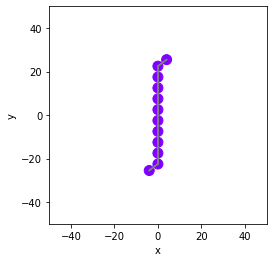

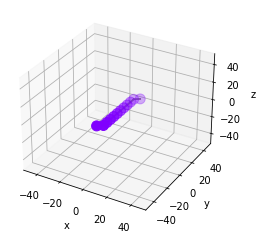

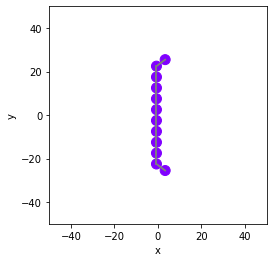

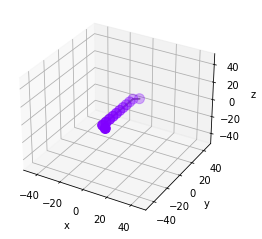


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:48<00:00,  9.74s/it]



Done! Averaged over 5 runs: 
 - Training time: 9.71s ± 0.81. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:56<00:00, 11.39s/it]



Done! Averaged over 5 runs: 
 - Training time: 11.36s ± 0.79. 
 - Best validation accuracy: 70.000 ± 24.495. 
- Test accuracy: 70.0 ± 24.5. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [01:05<00:00, 13.05s/it]



Done! Averaged over 5 runs: 
 - Training time: 13.03s ± 0.57. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



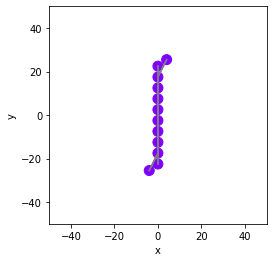

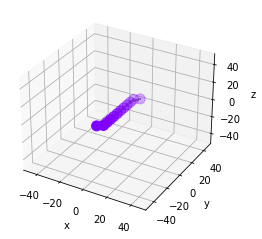

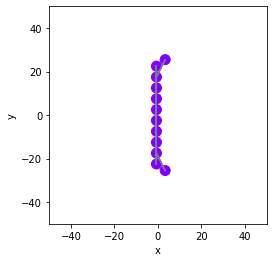

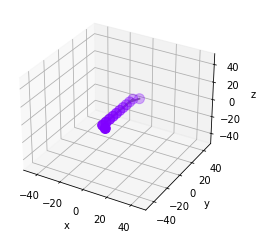


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:45<00:00,  9.15s/it]



Done! Averaged over 5 runs: 
 - Training time: 9.13s ± 0.74. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:55<00:00, 11.14s/it]



Done! Averaged over 5 runs: 
 - Training time: 11.12s ± 0.43. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [01:07<00:00, 13.41s/it]


Done! Averaged over 5 runs: 
 - Training time: 13.38s ± 0.99. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 



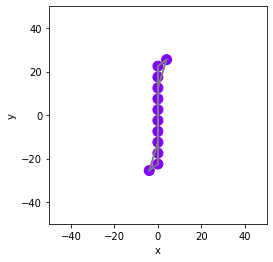

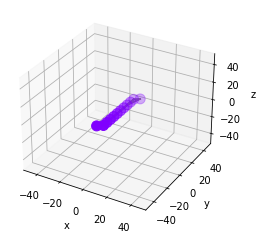

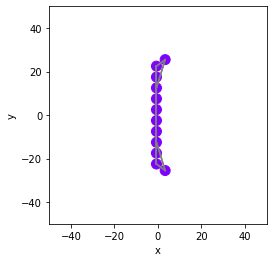

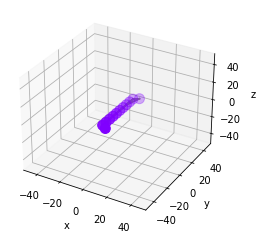


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:52<00:00, 10.54s/it]



Done! Averaged over 5 runs: 
 - Training time: 10.52s ± 0.61. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [01:03<00:00, 12.63s/it]



Done! Averaged over 5 runs: 
 - Training time: 12.60s ± 0.55. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [01:12<00:00, 14.59s/it]



Done! Averaged over 5 runs: 
 - Training time: 14.56s ± 0.25. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



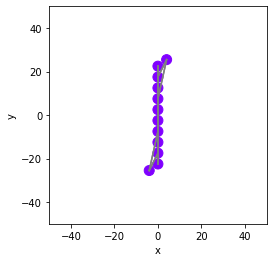

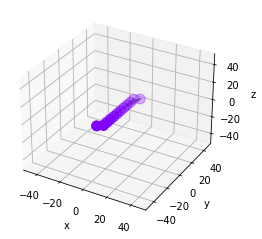

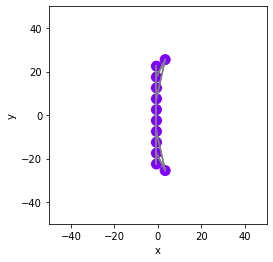

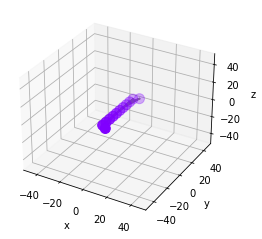


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:54<00:00, 10.93s/it]



Done! Averaged over 5 runs: 
 - Training time: 10.90s ± 0.61. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:59<00:00, 11.92s/it]



Done! Averaged over 5 runs: 
 - Training time: 11.90s ± 0.78. 
 - Best validation accuracy: 70.000 ± 24.495. 
- Test accuracy: 70.0 ± 24.5. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [01:12<00:00, 14.59s/it]



Done! Averaged over 5 runs: 
 - Training time: 14.57s ± 0.36. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



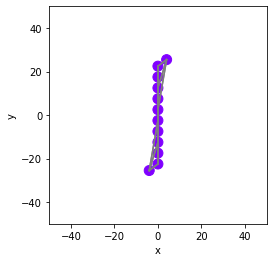

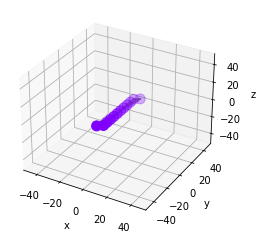

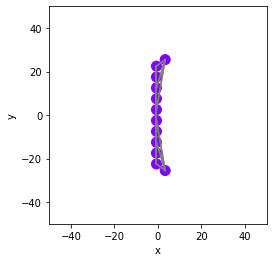

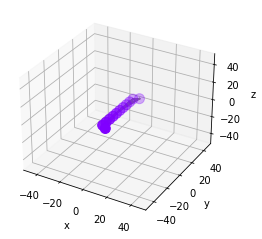


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [00:56<00:00, 11.36s/it]



Done! Averaged over 5 runs: 
 - Training time: 11.34s ± 0.97. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [01:06<00:00, 13.33s/it]



Done! Averaged over 5 runs: 
 - Training time: 13.31s ± 0.92. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 5/5 [01:15<00:00, 15.05s/it]


Done! Averaged over 5 runs: 
 - Training time: 15.03s ± 0.45. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

{0: [[50.0, 50.0, 50.0, 50.0, 50.0], [100.0, 50.0, 100.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0]], 1: [[50.0, 50.0, 50.0, 100.0, 50.0], [50.0, 50.0, 50.0, 50.0, 100.0], [50.0, 50.0, 100.0, 50.0, 50.0]], 2: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 3: [[50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 100.0, 100.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0]], 4: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]]}


In [ ]:
model_name = "gvp"
d = {} 

for i in range(5):

  k = 10
  d[i] = []
  # Create dataset
  dataset = create_kchains(k=k)

  new_dataset=[]
  for data in dataset:
      two_hop_data = n_hop(data, i)
      new_dataset.append(two_hop_data)
      plot_2d(data, lim=5*k)
      plot_3d(two_hop_data, lim=5*k)
  # Create dataloaders
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
  val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
  test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

  for num_layers in range(k // 2 , k // 2 + 3):

      print(f"\nNumber of layers: {num_layers}")
      
      model = {
          "mpnn": MPNNModel,
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "egnn": EGNNModel,
          "gvp": GVPGNNModel,
          "tfn": TFNModel,
          "mace": partial(MACEModel, correlation=2),
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
      
      best_val_acc, test_acc, train_time = run_experiment(
          model, 
          dataloader,
          val_loader, 
          test_loader,
          n_epochs=50,
          n_times=5,
          device=device,
          verbose=False
      )
      d[i].append(best_val_acc)

print(d)

In [ ]:
{0: [[50.0, 50.0, 50.0, 50.0, 50.0], [100.0, 50.0, 100.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0]], 1: [[50.0, 50.0, 50.0, 100.0, 50.0], [50.0, 50.0, 50.0, 50.0, 100.0], [50.0, 50.0, 100.0, 50.0, 50.0]], 2: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 3: [[50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 100.0, 100.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0]], 4: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]]}

In [ ]:
d = {0: [[50.0, 50.0, 50.0, 100.0, 100.0], [100.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 50.0, 100.0, 50.0], [50.0, 50.0, 50.0, 100.0, 100.0], [50.0, 50.0, 100.0, 100.0, 100.0], [50.0, 100.0, 100.0, 100.0, 50.0]], 1: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [50.0, 50.0, 50.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 50.0, 100.0, 100.0, 100.0]], 2: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 3: [[50.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 4: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]]}


In [ ]:
d = {0: [[50.0, 50.0, 50.0, 50.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [50.0, 100.0, 100.0, 50.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [50.0, 100.0, 100.0, 100.0, 100.0]], 1: [[50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 100.0, 50.0, 100.0], [50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 50.0, 50.0, 50.0], [50.0, 50.0, 100.0, 50.0, 50.0]], 2: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 3: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]], 4: [[100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0]]}


[ 60. 100. 100.  80. 100.  90.]
[50. 50. 70. 50. 50. 60.]
[100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100.]


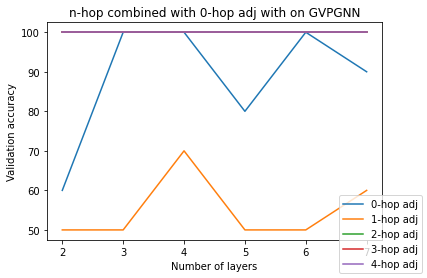

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline


def plot_res(d, name, title):
  fig, ax = plt.subplots()

  x = [2, 3,4,5,6,7]
  for key in d.keys():
    l = d[key]

    means = np.mean(l, axis= 1)
    #stds = np.std(l, axis= 1)
    print(means)
    ax.plot(x, means, label = str(key)+"-hop adj")

  plt.title(title)
  fig.legend(loc='lower right')
  plt.xlabel('Number of layers')
  plt.ylabel('Validation accuracy')


  plt.savefig(name+'.png')

In [ ]:
# Set model
model_name = "gvp"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

for num_layers in range(k // 2 , k + 3):

    print(f"\nNumber of layers: {num_layers}")
    
    model = {
        "mpnn": MPNNModel,
        "schnet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "egnn": EGNNModel,
        "gvp": GVPGNNModel,
        "tfn": TFNModel,
        "mace": partial(MACEModel, correlation=2),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
    
    best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:26<00:00,  8.62s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.61s ± 0.76. 
 - Best validation accuracy: 70.000 ± 24.495. 
- Test accuracy: 70.0 ± 24.5. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:55<00:00, 11.59s/it]



Done! Averaged over 10 runs: 
 - Training time: 11.57s ± 0.98. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [02:17<00:00, 13.78s/it]



Done! Averaged over 10 runs: 
 - Training time: 13.76s ± 0.51. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [02:45<00:00, 16.60s/it]



Done! Averaged over 10 runs: 
 - Training time: 16.58s ± 0.41. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [03:13<00:00, 19.39s/it]



Done! Averaged over 10 runs: 
 - Training time: 19.37s ± 0.55. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


  0%|          | 0/10 [00:09<?, ?it/s]


KeyboardInterrupt: ignored

In [ ]:
# Set model
model_name = "gvp"

# Create dataloaders
dataloader = DataLoader(new_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(new_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(new_dataset, batch_size=2, shuffle=False)
for num_layers in range(k // 2 , k + 3):

    print(f"\nNumber of layers: {num_layers}")
    
    model = {
        "mpnn": MPNNModel,
        "schnet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "egnn": EGNNModel,
        "gvp": GVPGNNModel,
        "tfn": TFNModel,
        "mace": partial(MACEModel, correlation=2),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
    
    best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:19<00:00,  7.96s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.95s ± 0.94. 
 - Best validation accuracy: 90.000 ± 20.000. 
- Test accuracy: 90.0 ± 20.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:48<00:00, 10.83s/it]



Done! Averaged over 10 runs: 
 - Training time: 10.81s ± 1.04. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [02:18<00:00, 13.86s/it]



Done! Averaged over 10 runs: 
 - Training time: 13.84s ± 0.53. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [02:46<00:00, 16.65s/it]



Done! Averaged over 10 runs: 
 - Training time: 16.62s ± 0.31. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [03:10<00:00, 19.07s/it]



Done! Averaged over 10 runs: 
 - Training time: 19.05s ± 0.56. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [03:38<00:00, 21.84s/it]


Done! Averaged over 10 runs: 
 - Training time: 21.81s ± 0.99. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



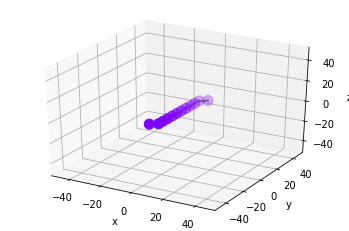

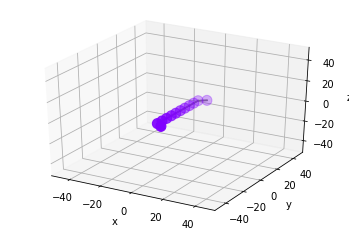

In [ ]:
k = 5

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    # plot_2d(data, lim=5*k)
    plot_3d(data, lim=5*k)

In [ ]:
# Set model
model_name = "gvp"

# Create dataloaders
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

for num_layers in range(k // 2 , k + 3, 4):

    print(f"\nNumber of layers: {num_layers}")
    
    model = {
        "mpnn": MPNNModel,
        "schnet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "egnn": EGNNModel,
        "gvp": GVPGNNModel,
        "tfn": TFNModel,
        "mace": partial(MACEModel, correlation=2),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
    
    best_val_acc, test_acc, train_time = run_experiment(
        model, 
        dataloader,
        val_loader, 
        test_loader,
        n_epochs=100,
        n_times=10,
        device=device,
        verbose=False
    )


Number of layers: 5
Running experiment for GVPGNNModel (cuda).


100%|██████████| 10/10 [02:40<00:00, 16.03s/it]



Done! Averaged over 10 runs: 
 - Training time: 16.02s ± 0.75. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 9
Running experiment for GVPGNNModel (cuda).


100%|██████████| 10/10 [04:29<00:00, 26.91s/it]


Done! Averaged over 10 runs: 
 - Training time: 26.89s ± 1.34. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 



### New Experiments

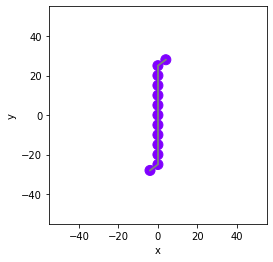

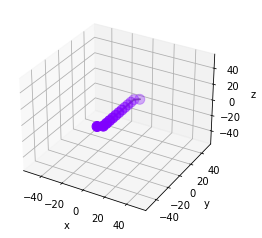

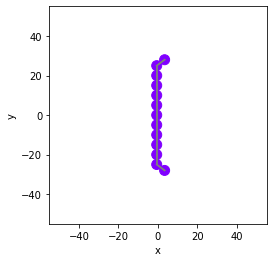

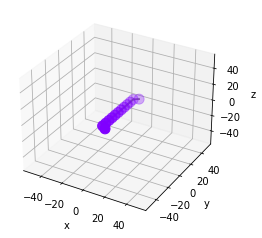


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:30<00:00,  3.01s/it]



Done! Averaged over 10 runs: 
 - Training time: 2.99s ± 0.47. 
 - Best validation accuracy: 60.000 ± 20.000. 
- Test accuracy: 60.0 ± 20.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:41<00:00,  4.13s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.11s ± 0.58. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:50<00:00,  5.04s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.02s ± 0.69. 
 - Best validation accuracy: 55.000 ± 15.000. 
- Test accuracy: 55.0 ± 15.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:00<00:00,  6.01s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.98s ± 0.87. 
 - Best validation accuracy: 85.000 ± 22.913. 
- Test accuracy: 85.0 ± 22.9. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:06<00:00,  6.70s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.67s ± 0.70. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:18<00:00,  7.87s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.84s ± 0.99. 
 - Best validation accuracy: 85.000 ± 22.913. 
- Test accuracy: 85.0 ± 22.9. 



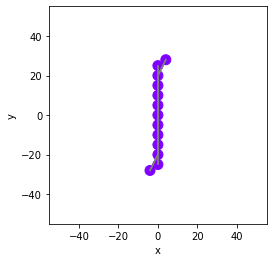

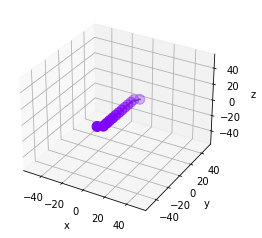

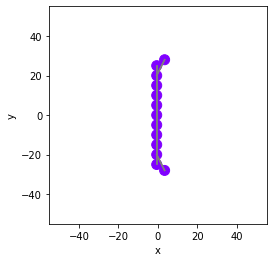

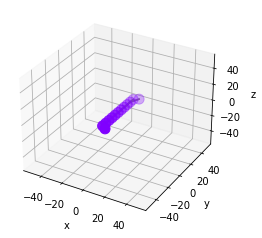


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:25<00:00,  2.57s/it]



Done! Averaged over 10 runs: 
 - Training time: 2.56s ± 0.34. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.90s ± 0.61. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:48<00:00,  4.88s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.85s ± 0.64. 
 - Best validation accuracy: 85.000 ± 22.913. 
- Test accuracy: 85.0 ± 22.9. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:57<00:00,  5.80s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.77s ± 0.65. 
 - Best validation accuracy: 80.000 ± 24.495. 
- Test accuracy: 80.0 ± 24.5. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:08<00:00,  6.81s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.78s ± 0.87. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:18<00:00,  7.90s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.87s ± 1.14. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 



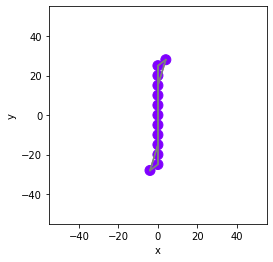

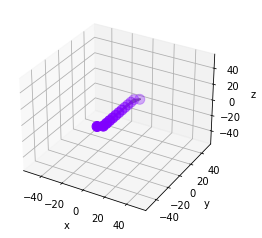

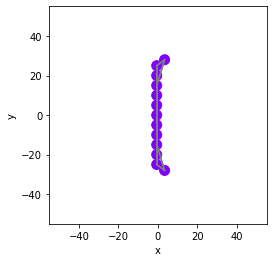

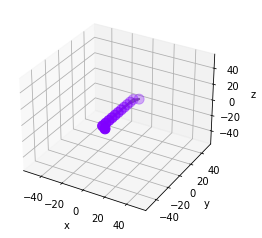


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:30<00:00,  3.06s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.04s ± 0.48. 
 - Best validation accuracy: 90.000 ± 20.000. 
- Test accuracy: 90.0 ± 20.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:42<00:00,  4.24s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.22s ± 0.66. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:53<00:00,  5.35s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.32s ± 0.63. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:04<00:00,  6.45s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.42s ± 0.82. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:14<00:00,  7.50s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.47s ± 0.68. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:29<00:00,  8.95s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.92s ± 0.82. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



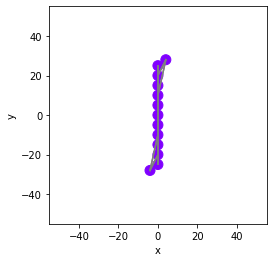

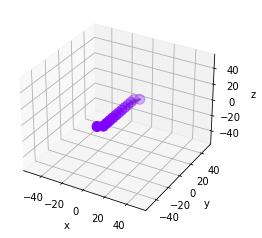

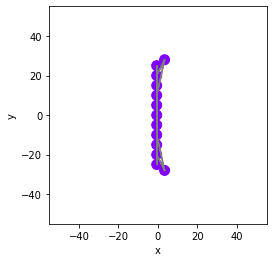

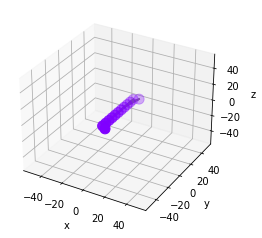


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:29<00:00,  2.97s/it]



Done! Averaged over 10 runs: 
 - Training time: 2.95s ± 0.47. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:39<00:00,  3.92s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.90s ± 0.68. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:52<00:00,  5.23s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.21s ± 0.82. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:05<00:00,  6.58s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.55s ± 0.82. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:15<00:00,  7.54s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.51s ± 0.93. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:27<00:00,  8.75s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.72s ± 0.72. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



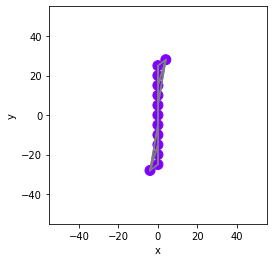

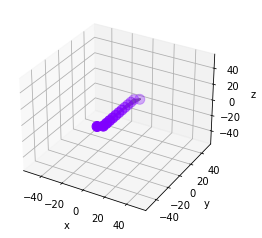

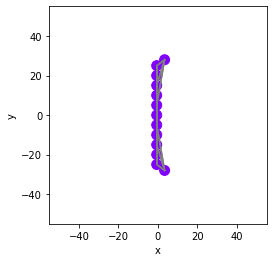

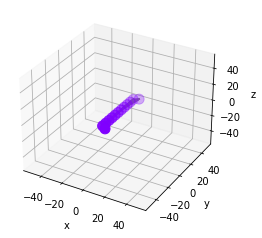


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:35<00:00,  3.53s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.51s ± 0.54. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.81s ± 0.64. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:02<00:00,  6.25s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.23s ± 0.73. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:15<00:00,  7.57s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.54s ± 0.75. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:25<00:00,  8.51s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.48s ± 0.88. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:41<00:00, 10.15s/it]



Done! Averaged over 10 runs: 
 - Training time: 10.12s ± 0.74. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

[ 60.  50.  55.  85. 100.  85.]
[ 95. 100.  85.  80. 100.  95.]
[ 90. 100. 100. 100. 100. 100.]
[ 95. 100.  95. 100. 100. 100.]
[100. 100. 100. 100. 100. 100.]


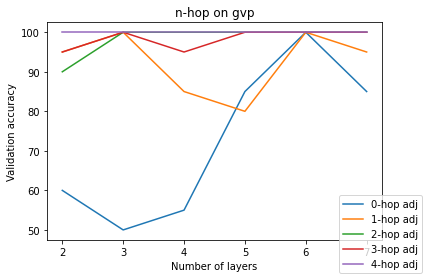

In [ ]:
model_name = "gvp"
d = {} 

for i in range(5):

  k = 11
  d[i] = []
  # Create dataset
  dataset = create_kchains(k=k)

  new_dataset=[]
  for data in dataset:
      two_hop_data = n_hop(data, i)
      new_dataset.append(two_hop_data)
      plot_2d(data, lim=5*k)
      plot_3d(two_hop_data, lim=5*k)
  # Create dataloaders
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
  val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
  test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

  for num_layers in range(k // 2 - 3 , k // 2 + 3):

      print(f"\nNumber of layers: {num_layers}")
      
      model = {
          "mpnn": MPNNModel,
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "egnn": EGNNModel,
          "gvp": GVPGNNModel,
          "tfn": TFNModel,
          "mace": partial(MACEModel, correlation=2),
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
      
      best_val_acc, test_acc, train_time = run_experiment(
          model, 
          dataloader,
          val_loader, 
          test_loader,
          n_epochs=30,
          n_times=10,
          device=device,
          verbose=False
      )
      d[i].append(best_val_acc)

plot_res(d, 'n-hop_on_gvp', 'n-hop on gvp')

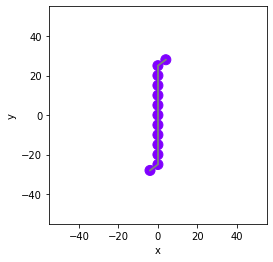

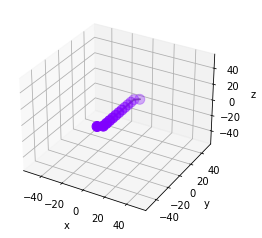

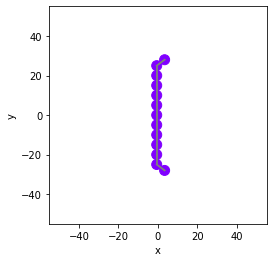

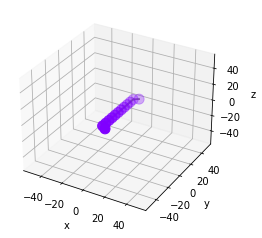


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:26<00:00,  2.64s/it]



Done! Averaged over 10 runs: 
 - Training time: 2.63s ± 0.35. 
 - Best validation accuracy: 95.000 ± 15.000. 
- Test accuracy: 95.0 ± 15.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:41<00:00,  4.15s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.13s ± 0.68. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:50<00:00,  5.09s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.07s ± 0.80. 
 - Best validation accuracy: 55.000 ± 15.000. 
- Test accuracy: 55.0 ± 15.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:59<00:00,  5.95s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.92s ± 0.90. 
 - Best validation accuracy: 85.000 ± 22.913. 
- Test accuracy: 85.0 ± 22.9. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:07<00:00,  6.72s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.69s ± 0.78. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:17<00:00,  7.76s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.73s ± 0.64. 
 - Best validation accuracy: 85.000 ± 22.913. 
- Test accuracy: 85.0 ± 22.9. 



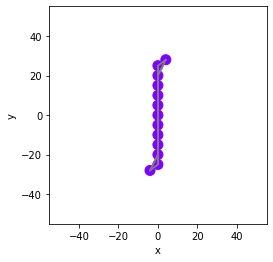

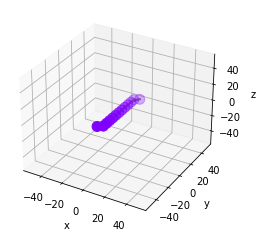

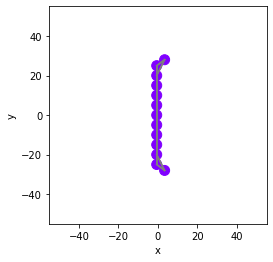

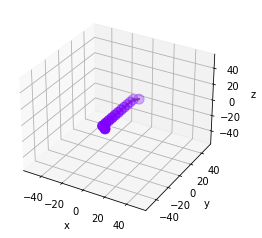


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:32<00:00,  3.22s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.20s ± 0.56. 
 - Best validation accuracy: 65.000 ± 22.913. 
- Test accuracy: 65.0 ± 22.9. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:44<00:00,  4.41s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.39s ± 0.68. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:00<00:00,  6.01s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.98s ± 0.76. 
 - Best validation accuracy: 55.000 ± 15.000. 
- Test accuracy: 55.0 ± 15.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:09<00:00,  6.94s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.91s ± 0.91. 
 - Best validation accuracy: 55.000 ± 15.000. 
- Test accuracy: 55.0 ± 15.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:21<00:00,  8.17s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.14s ± 0.90. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:35<00:00,  9.51s/it]



Done! Averaged over 10 runs: 
 - Training time: 9.48s ± 0.91. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 



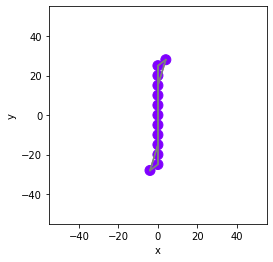

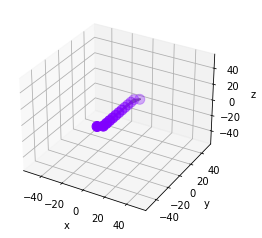

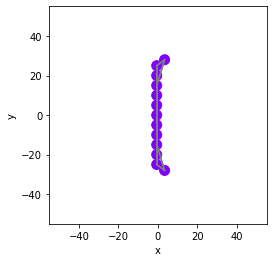

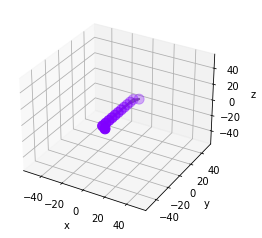


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:30<00:00,  3.09s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.08s ± 0.56. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:43<00:00,  4.33s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.31s ± 0.58. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:54<00:00,  5.41s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.38s ± 0.57. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:04<00:00,  6.48s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.45s ± 0.87. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:15<00:00,  7.54s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.52s ± 0.66. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:28<00:00,  8.86s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.82s ± 0.75. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



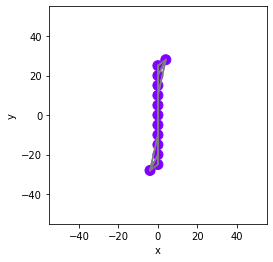

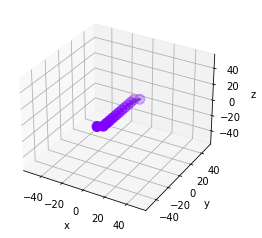

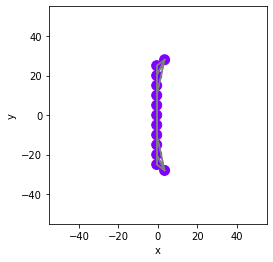

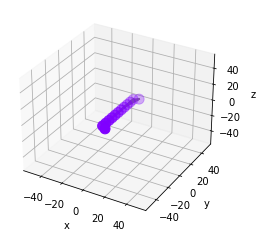


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:32<00:00,  3.20s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.18s ± 0.46. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:43<00:00,  4.36s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.34s ± 0.69. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:59<00:00,  5.92s/it]



Done! Averaged over 10 runs: 
 - Training time: 5.90s ± 0.77. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:15<00:00,  7.52s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.49s ± 0.82. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:24<00:00,  8.50s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.47s ± 0.95. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:40<00:00, 10.07s/it]



Done! Averaged over 10 runs: 
 - Training time: 10.03s ± 0.84. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 



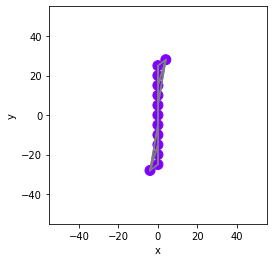

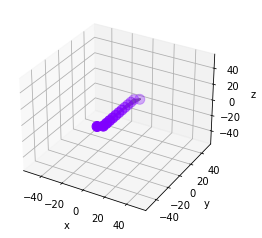

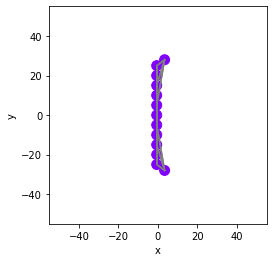

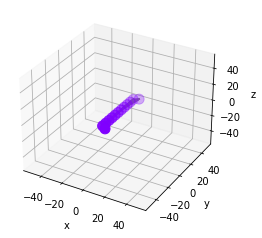


Number of layers: 2
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:34<00:00,  3.47s/it]



Done! Averaged over 10 runs: 
 - Training time: 3.45s ± 0.55. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 3
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [00:48<00:00,  4.83s/it]



Done! Averaged over 10 runs: 
 - Training time: 4.81s ± 0.62. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 4
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:01<00:00,  6.17s/it]



Done! Averaged over 10 runs: 
 - Training time: 6.14s ± 0.73. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 5
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:13<00:00,  7.30s/it]



Done! Averaged over 10 runs: 
 - Training time: 7.27s ± 0.83. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:27<00:00,  8.73s/it]



Done! Averaged over 10 runs: 
 - Training time: 8.70s ± 1.37. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 7
Running experiment for GVPGNNModel (cpu).


100%|██████████| 10/10 [01:41<00:00, 10.17s/it]



Done! Averaged over 10 runs: 
 - Training time: 10.13s ± 0.71. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 

[ 95.  50.  55.  85. 100.  85.]
[65. 50. 55. 55. 50. 50.]
[100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100.]
[100. 100. 100. 100. 100. 100.]


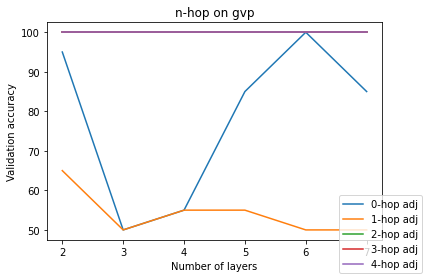

In [ ]:
model_name = "gvp"
d = {} 

for i in range(5):

  k = 11
  d[i] = []
  # Create dataset
  dataset = create_kchains(k=k)

  new_dataset=[]
  for data in dataset:
      two_hop_data = n_hop_plus_init(data, i)
      new_dataset.append(two_hop_data)
      plot_2d(data, lim=5*k)
      plot_3d(two_hop_data, lim=5*k)
  # Create dataloaders
  dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
  val_loader = DataLoader(dataset, batch_size=2, shuffle=False)
  test_loader = DataLoader(dataset, batch_size=2, shuffle=False)

  for num_layers in range(k // 2 - 3 , k // 2 + 3):

      print(f"\nNumber of layers: {num_layers}")
      
      model = {
          "mpnn": MPNNModel,
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "egnn": EGNNModel,
          "gvp": GVPGNNModel,
          "tfn": TFNModel,
          "mace": partial(MACEModel, correlation=2),
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)
      
      best_val_acc, test_acc, train_time = run_experiment(
          model, 
          dataloader,
          val_loader, 
          test_loader,
          n_epochs=30,
          n_times=10,
          device=device,
          verbose=False
      )
      d[i].append(best_val_acc)

plot_res(d, 'n-hop_on_gvp', 'n-hop on gvp')